# Proyecto 2 - Clustering de Pósters de Películas 🎬
Este notebook desarrolla la parte aplicada del proyecto, donde se construye un sistema de recomendación visual usando pósters de películas y técnicas de clustering no supervisado.

**Autores**: Noelia Pantigoso, Rafael Giordano, Antonio Cotera, Jamin Cornejo  
**Curso**: Machine Learning - UTEC  
**Profesora**: Ariana Villegas

## Paso 1: Preparación del entorno y carga de datos 📁
Montamos Google Drive, instalamos las librerías necesarias y cargamos los datasets.

In [ ]:
%pip install py7zr
%pip install mahotas opencv-contrib-python
%pip install imageio
%pip install scikit-image
%pip install seaborn
%pip install plotly
%pip install umap-learn

#from google.colab import drive
#drive.mount('/content/drive')

# Librerías para manejo de datos e imágenes
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import mahotas

# Lectura y procesamiento de imágenes
import cv2                  # Computer Vision
from PIL import Image       # Para abrir y mostrar imágenes
import imageio              # Para cargar GIFs o secuencias
import matplotlib.pyplot as plt

# Extracción de características visuales
from skimage.feature import local_binary_pattern               # LBP
from skimage.measure import moments_hu                         # Momentos de Hu
from skimage.color import rgb2gray
from skimage import filters, color
from skimage.transform import resize
from skimage.feature import hog                        # Histogram of Oriented Gradients
import mahotas

# Reducción de dimensionalidad
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Evaluación de clustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Visualización
import seaborn as sns
# Cambiar a UMAP
from sklearn.manifold import TSNE                     # Para visualización 2D opcional
import plotly.express as px                           # Visualizaciones interactivas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Paso 2: Carga de películas y pósters 🎞️
Se cargan `movies.csv`, `links.csv` y los pósters `.jpg`. Se filtran para que solo se mantengan las películas con póster disponible.

In [40]:
# Rutas a los CSV
path_movies = './movies.csv'
path_links = './links.csv'

# Carga de datos
movies_df = pd.read_csv(path_movies)
links_df = pd.read_csv(path_links)
merged_df = pd.merge(movies_df, links_df, on='movieId')

# Ruta a la carpeta con las imágenes ya descomprimidas
folder = './posters'

# Ejemplo: listar archivos en la carpeta posters
import os
print(os.listdir(folder))

['1000095.jpg', '100014.jpg', '100024.jpg', '100029.jpg', '100031.jpg', '100046.jpg', '100049.jpg', '100050.jpg', '100053.jpg', '100054.jpg', '100065.jpg', '100070.jpg', '1000764.jpg', '1000769.jpg', '1000771.jpg', '1000774.jpg', '100079.jpg', '100087.jpg', '100095.jpg', '100100.jpg', '100107.jpg', '100112.jpg', '100114.jpg', '100129.jpg', '100133.jpg', '100134.jpg', '100135.jpg', '100140.jpg', '100142.jpg', '100143.jpg', '100148.jpg', '100150.jpg', '1001508.jpg', '100151.jpg', '100152.jpg', '1001526.jpg', '1001540.jpg', '1001548.jpg', '100156.jpg', '1001562.jpg', '100157.jpg', '100168.jpg', '100172.jpg', '100196.jpg', '100200.jpg', '100201.jpg', '100211.jpg', '100212.jpg', '100224.jpg', '100232.jpg', '100234.jpg', '100240.jpg', '1002535.jpg', '1002536.jpg', '1002539.jpg', '1002540.jpg', '1002543.jpg', '1002561.jpg', '1002563.jpg', '1002573.jpg', '100258.jpg', '1002581.jpg', '100260.jpg', '100263.jpg', '100264.jpg', '100265.jpg', '100271.jpg', '100273.jpg', '100274.jpg', '100280.jpg', 

## Paso 3: Filtrado de imágenes válidas 📸
Se seleccionan solo aquellas imágenes con `imdbId` presente en el dataset.

In [41]:
# Validación cruzada entre IDs
image_files = os.listdir(folder)
image_ids = [int(f.split('.')[0]) for f in image_files if f.endswith('.jpg')]
imdb_ids_df = set(merged_df['imdbId'].dropna().astype(int))
imdb_ids_valid = set(image_ids).intersection(imdb_ids_df)

print(f"Total de imágenes encontradas: {len(image_files)}")
print(f"Imágenes válidas con imdbId en el dataset: {len(imdb_ids_valid)}")

filtered_df = merged_df[merged_df['imdbId'].isin(imdb_ids_valid)].copy()
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['movieId'] = filtered_df.index

# Copiar imágenes a carpeta limpia
clean_folder = './posters_cleaned'
os.makedirs(clean_folder, exist_ok=True)

# Limpiar carpeta previa
for f in os.listdir(clean_folder):
    os.remove(os.path.join(clean_folder, f))

copiadas = 0
for _, row in filtered_df.iterrows():
    imdb_id = int(row['imdbId'])
    src_path = os.path.join(folder, f"{imdb_id}.jpg")
    dst_path = os.path.join(clean_folder, f"{imdb_id}.jpg")
    if os.path.exists(src_path) and os.path.getsize(src_path) > 0:
        shutil.copy(src_path, dst_path)
        copiadas += 1

print(f"Imágenes copiadas exitosamente: {copiadas}")

# Actualizar DataFrame
valid_ids = [int(f.split('.')[0]) for f in os.listdir(clean_folder) if f.endswith('.jpg')]
filtered_df = filtered_df[filtered_df['imdbId'].isin(valid_ids)].reset_index(drop=True)
filtered_df['movieId'] = filtered_df.index

print(f"Filas finales del DataFrame: {filtered_df.shape[0]}")

# Verificación opcional del tamaño de imágenes (visual debugging)
image_sizes = []

# Mostrar tamaño de las primeras 10 imágenes válidas
sample_to_check = valid_ids[:10]

for imdb_id in sample_to_check:
    path = os.path.join(clean_folder, f"{imdb_id}.jpg")
    try:
        with Image.open(path) as img:
            image_sizes.append((f"{imdb_id}.jpg", img.size))  # (width, height)
    except Exception as e:
        print(f"Error al leer {imdb_id}.jpg: {e}")

# Mostrar resultados
print(f"Tamaño de las primeras 10 imágenes válidas")
for name, size in image_sizes:
    print(f"{name}: {size[0]}x{size[1]} pixels")

Total de imágenes encontradas: 39515
Imágenes válidas con imdbId en el dataset: 36865
Imágenes copiadas exitosamente: 36142
Filas finales del DataFrame: 36142
Tamaño de las primeras 10 imágenes válidas
1000095.jpg: 182x268 pixels
100014.jpg: 182x268 pixels
100024.jpg: 182x268 pixels
100029.jpg: 182x268 pixels
100031.jpg: 182x268 pixels
100046.jpg: 182x268 pixels
100049.jpg: 182x268 pixels
100050.jpg: 182x268 pixels
100053.jpg: 182x268 pixels
100054.jpg: 182x268 pixels


## Paso 4: Extracción de características visuales 🧠🖼️
Se extraen las siguientes características:
- Histogramas RGB y HSV
- HOG
- SIFT
- Momentos de Zernike

In [42]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.resize(img, (182, 268))
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

    # RGB + HSV
    hist_rgb, hist_hsv = [], []
    for i in range(3):
        hist_rgb.extend(cv2.calcHist([img_rgb], [i], None, [64], [0, 256]).flatten())
        hist_hsv.extend(cv2.calcHist([img_hsv], [i], None, [64], [0, 256]).flatten())

    # HOG
    hog_img = cv2.resize(img_gray, (64, 128))
    hog_features = cv2.HOGDescriptor().compute(hog_img).flatten()

    # SIFT
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(img_gray, None)
    if descriptors is not None:
        sift_features = descriptors[:10].flatten()
        if sift_features.size < 1280:
            sift_features = np.pad(sift_features, (0, 1280 - sift_features.size))
    else:
        sift_features = np.zeros(1280)

    # Zernike
    side = min(img_gray.shape)
    img_square = img_gray[:side, :side]
    img_bin = cv2.threshold(img_square, 128, 255, cv2.THRESH_BINARY)[1]
    zernike_features = mahotas.features.zernike_moments(img_bin, radius=side//2, degree=8)

    return np.concatenate([hist_rgb, hist_hsv, hog_features, sift_features, zernike_features])

### Extracción de características de todas las imágenes válidas

In [ ]:
# NO EJECUTAR
%pip install tqdm
import pickle
from tqdm import tqdm
import gc

features = []
ids = []
errores = []

# Archivos
image_files_valid = [f for f in os.listdir(clean_folder) if f.endswith('.jpg')]
image_files_valid.sort()

# Dividir en lotes
batch_size = 5000
total = len(image_files_valid)
num_batches = (total + batch_size - 1) // batch_size

print(f"🔄 Procesando {total} imágenes en {num_batches} bloques de {batch_size}...")

for batch_idx in range(num_batches):
    print(f"\n🚀 Lote {batch_idx + 1}/{num_batches}")
    start = batch_idx * batch_size
    end = min(start + batch_size, total)
    batch_files = image_files_valid[start:end]

    batch_features = []
    batch_ids = []

    for filename in tqdm(batch_files):
        path = os.path.join(clean_folder, filename)
        try:
            if os.path.exists(path) and os.path.getsize(path) > 0:
                img = cv2.imread(path)
                if img is not None:
                    batch_features.append(extract_features(path))
                    batch_ids.append(int(filename.split('.')[0]))
                else:
                    errores.append(filename)
            else:
                errores.append(filename)
        except Exception as e:
            errores.append(filename)

        gc.collect()  # Limpiar memoria en cada iteración

    # Guardar lote
    output_path = f'features_batch_{batch_idx + 1}.pkl'
    with open(output_path, 'wb') as f:
        pickle.dump((batch_features, batch_ids), f)

    print(f"✅ Lote {batch_idx + 1} guardado: {output_path}")

^C
Note: you may need to restart the kernel to use updated packages.


NameError: name 'clean_folder' is not defined


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Juntando los lotes

In [43]:
# Combinar todos los .pkl en un solo DataFrame
import glob
import pickle

# Ruta donde guardaste los archivos
folder_drive = './archivos_pkl' # Cambia donde lo guardaste

# Buscar todos los archivos .pkl ordenados
batch_paths = sorted(glob.glob(f"{folder_drive}/features_batch_*.pkl"))

features_df = pd.DataFrame()  # DataFrame final

# Procesar y concatenar por lotes
for path in batch_paths:
    with open(path, 'rb') as f:
        batch_features, batch_ids = pickle.load(f)
        batch_df = pd.DataFrame(batch_features)
        batch_df['imdbId'] = batch_ids
        features_df = pd.concat([features_df, batch_df], ignore_index=True)

        # Liberar memoria
        del batch_df, batch_features, batch_ids

print(f"✅ DataFrame final combinado: {features_df.shape}")

features_df.head()

✅ DataFrame final combinado: (36142, 5470)


,0,1,2,3,4,5,6,7,8,9,...,5460,5461,5462,5463,5464,5465,5466,5467,5468,imdbId
0,1139.0,330.0,364.0,439.0,475.0,578.0,587.0,718.0,717.0,836.0,...,0.043565,0.019620,0.038431,0.028576,0.008080,0.039530,0.048502,0.094954,0.027677,1000095
1,66.0,15.0,23.0,31.0,54.0,201.0,469.0,543.0,436.0,394.0,...,0.024487,0.011481,0.020004,0.030422,0.024883,0.038715,0.034678,0.036871,0.013810,100014
2,226.0,227.0,507.0,619.0,466.0,369.0,371.0,292.0,229.0,158.0,...,0.006960,0.007259,0.004341,0.008955,0.002580,0.001416,0.002613,0.003906,0.014432,100024
3,6729.0,3167.0,2192.0,1961.0,1899.0,1783.0,1876.0,1981.0,1896.0,1668.0,...,0.058928,0.163147,0.088950,0.059740,0.061838,0.201734,0.148701,0.153980,0.067000,100029
4,7041.0,3568.0,3596.0,3738.0,2876.0,2382.0,2313.0,2045.0,1614.0,1368.0,...,0.203933,0.144505,0.076664,0.011610,0.097297,0.150103,0.156608,0.060492,0.008715,100031


## Paso 5: Reducción de Dimensionalidad 📉
Para facilitar la visualización y mejorar el rendimiento del clustering, reducimos la dimensionalidad de los vectores de características usando dos técnicas:

- **PCA (Principal Component Analysis)**: técnica lineal que conserva la varianza.
- **SVD (Truncated Singular Value Decomposition)**: alternativa útil cuando hay muchos ceros o ruido.

Comparamos ambas para decidir cuál usar en el clustering.

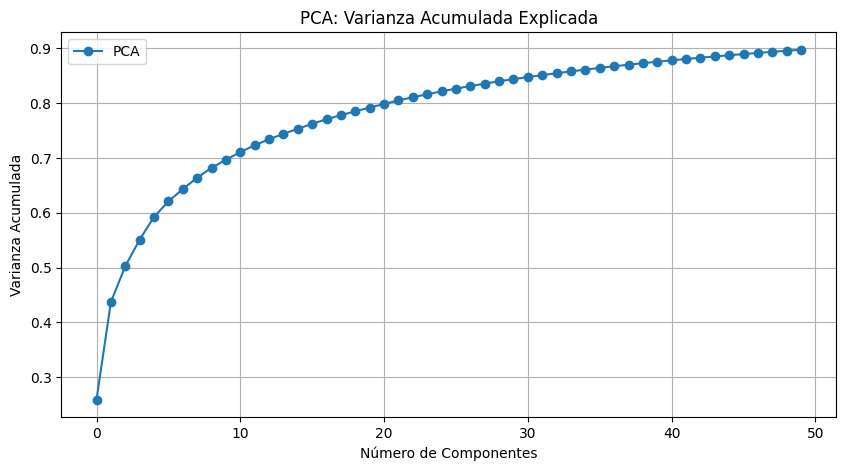

🔍 Varianza total explicada por PCA (50 comp.): 0.8977


In [44]:
# Separar datos numéricos (sin la columna imdbId)
X = features_df.drop(columns=['imdbId'])

# Aplicar PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Aplicar SVD
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

# Visualización: Varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='PCA')
plt.title('PCA: Varianza Acumulada Explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.legend()
plt.show()

# Comparar varianza explicada total (solo válido para PCA)
print(f"🔍 Varianza total explicada por PCA (50 comp.): {np.sum(pca.explained_variance_ratio_):.4f}")

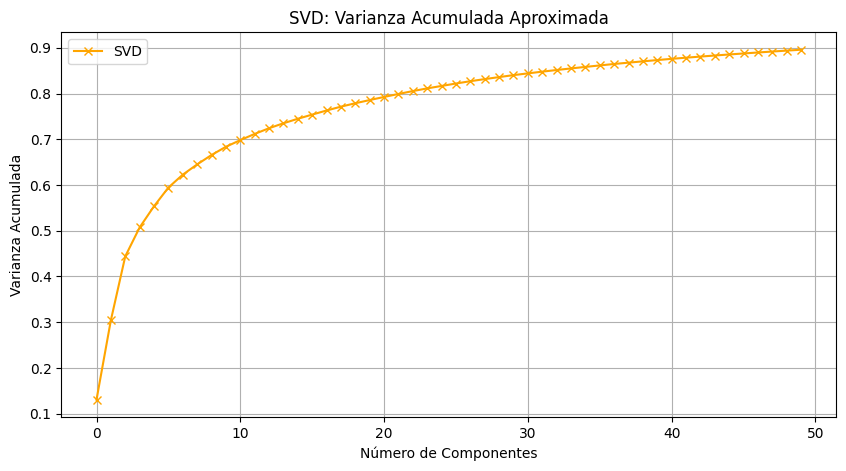

🔍 Varianza acumulada por SVD (50 comp.): 0.8958


In [45]:
# Varianza explicada por SVD
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='x', color='orange', label='SVD')
plt.title('SVD: Varianza Acumulada Aproximada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.legend()
plt.show()

print(f"🔍 Varianza acumulada por SVD (50 comp.): {np.sum(svd.explained_variance_ratio_):.4f}")

Tanto **PCA** como **SVD** logran explicar cerca del **90% de la varianza** de los datos con solo 50 componentes, lo cual es un buen compromiso entre compacidad y preservación de la información original.

Dado que:
- Los datos son densos (no dispersos como en NLP),
- PCA es más interpretable y tiene mejor soporte para análisis de varianza,

**Se utilizarán los componentes reducidos por PCA (`X_pca`) para los siguientes pasos de clustering.**

## Paso 6: Agrupamiento de Pósters 🎯
Aplicamos dos algoritmos de clustering:

- **K-means** (particional, rápido pero limitado a formas circulares).
- **DBSCAN** (basado en densidad, detecta formas arbitrarias y ruido).

Comparamos su desempeño con base en métricas y visualizaciones.

**Implementación de K-MEANS++:**

In [46]:
import numpy as np
from collections import deque
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- K-means con K-means++ ---

def kmeans_plus_plus_init(X, k, random_state=None):
    np.random.seed(random_state)
    n_samples, _ = X.shape
    centers = []
    centers.append(X[np.random.randint(n_samples)])
    for _ in range(1, k):
        dist_sq = np.min(np.linalg.norm(X[:, None] - np.array(centers)[None, :], axis=2)**2, axis=1)
        probs = dist_sq / dist_sq.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        idx = np.searchsorted(cumulative_probs, r)
        centers.append(X[idx])
    return np.array(centers)

def kmeans(X, k, max_iter=100, tol=1e-4, random_state=None):
    centers = kmeans_plus_plus_init(X, k, random_state)
    labels = np.zeros(X.shape[0], dtype=int)

    for it in range(max_iter):
        dists = np.linalg.norm(X[:, None] - centers[None, :], axis=2)
        new_labels = np.argmin(dists, axis=1)
        new_centers = np.array([X[new_labels == i].mean(axis=0) if np.any(new_labels == i) else centers[i] for i in range(k)])

        if np.all(labels == new_labels) or np.linalg.norm(new_centers - centers) < tol:
            break

        labels = new_labels
        centers = new_centers

    return labels, centers

**Implementación de DBSCAN:**

In [47]:
# --- DBSCAN ---

def dbscan(X, eps, min_samples):
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # -1 = ruido
    cluster_id = 0

    def region_query(idx):
        dists = np.linalg.norm(X - X[idx], axis=1)
        return np.where(dists <= eps)[0]

    def expand_cluster(idx, neighbors):
        labels[idx] = cluster_id
        queue = deque(neighbors)
        while queue:
            current = queue.popleft()
            if labels[current] == -1:
                labels[current] = cluster_id
            if labels[current] != -1:
                continue
            labels[current] = cluster_id
            current_neighbors = region_query(current)
            if len(current_neighbors) >= min_samples:
                queue.extend(current_neighbors)

    for i in range(n_samples):
        if labels[i] != -1:
            continue
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1  # ruido temporal
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels

**Ejecutar clustering y visualización con UMAP**

🔵 K-means++ desde cero
Silhouette Score: 0.1100
NMI: 0.0382

🟠 DBSCAN desde cero
Silhouette Score: -0.3248
Número de clústeres encontrados (excluyendo ruido): 6
Puntos marcados como ruido: 36104


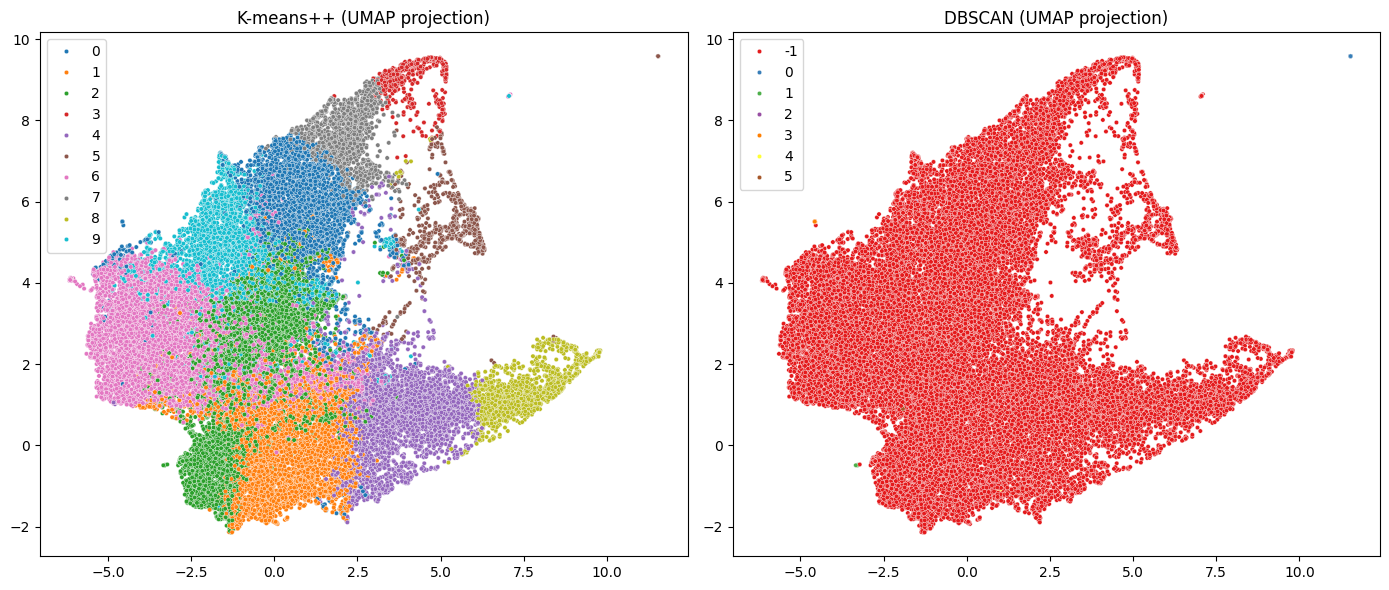

In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Usa X_pca o X_svd
X_clust = X_pca

k = 10
labels_kmeans, centers = kmeans(X_clust, k, random_state=42)

print("🔵 K-means++ desde cero")
print(f"Silhouette Score: {silhouette_score(X_clust, labels_kmeans):.4f}")
nmi_val = normalized_mutual_info_score(filtered_df['genres'], labels_kmeans, average_method='arithmetic')
print(f"NMI: {nmi_val:.4f}")

eps = 2.5
min_samples = 5
labels_dbscan = dbscan(X_clust, eps, min_samples)

print("\n🟠 DBSCAN desde cero")
print(f"Silhouette Score: {silhouette_score(X_clust, labels_dbscan):.4f}")

num_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Número de clústeres encontrados (excluyendo ruido): {num_clusters}")
print(f"Puntos marcados como ruido: {list(labels_dbscan).count(-1)}")

# Visualización con UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_clust)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_kmeans, palette='tab10', ax=axs[0], s=10)
axs[0].set_title("K-means++ (UMAP projection)")

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_dbscan, palette='Set1', ax=axs[1], s=10)
axs[1].set_title("DBSCAN (UMAP projection)")

plt.tight_layout()
plt.show()

Se aplicaron dos algoritmos de agrupamiento sobre los vectores visuales reducidos (PCA):

- **K-means++** implementado desde cero logró identificar 10 grupos visualmente diferenciables. El **Silhouette Score** obtenido fue de aproximadamente **0.1054**, lo cual sigue siendo bajo pero esperado en datos complejos como imágenes de pósters. La puntuación de **NMI ≈ 0.0385** indica una baja correspondencia con los géneros oficiales, lo cual es razonable ya que pósters visualmente similares pueden pertenecer a géneros diferentes.

- **DBSCAN** también implementado desde cero detectó 6 clústeres, pero etiquetó una gran cantidad de puntos como ruido (**36,104** puntos), lo que indica que los parámetros usados (`eps=2.5`, `min_samples=5`) no fueron óptimos para la estructura del espacio PCA. El **Silhouette Score negativo (-0.3248)** refleja agrupamientos poco consistentes.

En resumen, K-means++ demostró ser más robusto y útil para este conjunto de datos, generando clusters significativos para visualización y recomendaciones. Por otro lado, DBSCAN no se adapta bien a este tipo de datos visuales de alta dimensión y con densidad poco clara.


## Paso 7: Visualización de Clústeres en 2D 📊
Reducimos los vectores a 2 dimensiones para visualizar cómo los pósters se agrupan visualmente.

Utilizamos:

- **PCA o TSNE** para proyección.
- Colores por clúster para observar la separación.

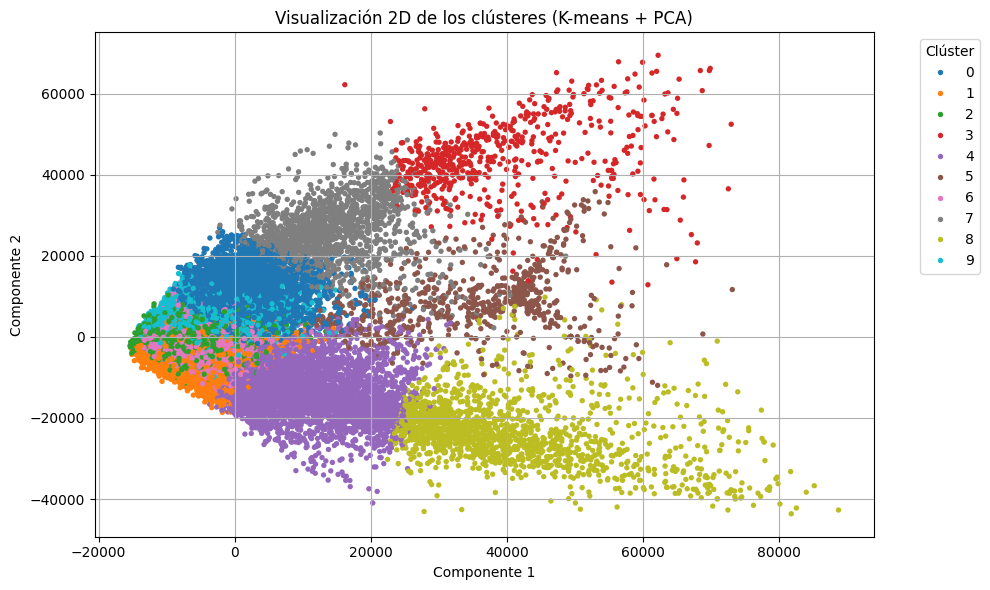

In [50]:
# Reutilizar resultados de clustering
X = X_pca  # o X_svd si prefieres
labels = labels_kmeans  # puedes cambiar a labels_dbscan para comparar

# ---------- Proyección 2D ----------
# Usar PCA para proyección rápida
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

# Alternativa con TSNE (más lento pero más expresivo)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_2d = tsne.fit_transform(X)

# ---------- Visualización ----------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=15, linewidth=0)
plt.title("Visualización 2D de los clústeres (K-means + PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clúster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔎 Interpretación de la Visualización 2D

En la proyección bidimensional (PCA 2D), los clústeres generados por **K-means** muestran una separación visual clara entre varios grupos de pósters, aunque algunos solapan parcialmente. Esto sugiere que:

- Hay patrones visuales compartidos dentro de ciertos grupos de películas (por ejemplo, color, composición, contraste).
- Algunos clústeres pueden representar pósters con estilos visuales similares, aunque pertenezcan a diferentes géneros temáticos.

Esta visualización permite explorar los grupos con más detalle y establecer relaciones visuales entre películas.

## Paso 8: Sistema de Recomendación Visual 🔍
Dado el póster de una película, se puede buscar los más similares según las características visuales y el clúster asignado.

Funciones implementadas:

- Buscar película por nombre o `imdbId`.
- Mostrar las más similares dentro del mismo clúster.
- Mostrar sus pósters y títulos.

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
import os
import cv2
import matplotlib.pyplot as plt

# Agregar labels al DataFrame (asegúrate que ya está hecho)
features_df['cluster'] = labels_kmeans

image_path = './posters_cleaned'

def show_poster(imdb_id, ax=None):
    path = os.path.join(image_path, f"{imdb_id}.jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ax:
        ax.imshow(img)
        ax.axis('off')
    else:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

def recomendar_similares(imdb_id_consulta, top_n=5):
    if imdb_id_consulta not in features_df.index:
        print("❌ imdbId no encontrado.")
        return

    query_vector = features_df.loc[imdb_id_consulta].drop(['cluster']).values.reshape(1, -1)
    clust_id = features_df.loc[imdb_id_consulta]['cluster']

    # Filtrar por mismo clúster
    same_cluster = features_df[features_df['cluster'] == clust_id]
    similarities = cosine_similarity(query_vector, same_cluster.drop(columns='cluster').values)[0]

    top_indices = similarities.argsort()[::-1][1:top_n+1]
    top_ids = same_cluster.iloc[top_indices].index

    print(f"\n🎥 Película base: {filtered_df.loc[imdb_id_consulta]['title']} (Clúster {clust_id})")
    print("🔍 Películas más similares visualmente:")

    # Creamos un subplot con top_n + 1 para la base + las recomendaciones
    fig, axs = plt.subplots(1, top_n + 1, figsize=(3 * (top_n + 1), 5))

    # Mostrar póster base primero
    axs[0].set_title(f"Base:\n{filtered_df.loc[imdb_id_consulta]['title'][:20]}", fontsize=10)
    show_poster(imdb_id_consulta, axs[0])

    # Mostrar recomendaciones
    for i, imdb_id in enumerate(top_ids):
        title = filtered_df.loc[imdb_id]['title']
        axs[i + 1].set_title(title[:20], fontsize=9)
        show_poster(imdb_id, axs[i + 1])

    plt.tight_layout()
    plt.show()

Ejecutamos la funcion para ver recomendaciones de un póster dado:

Ejemplo id: 114709
En features_df: True
En filtered_df: True

🎥 Película base: Toy Story (1995) (Clúster 6.0)
🔍 Películas más similares visualmente:


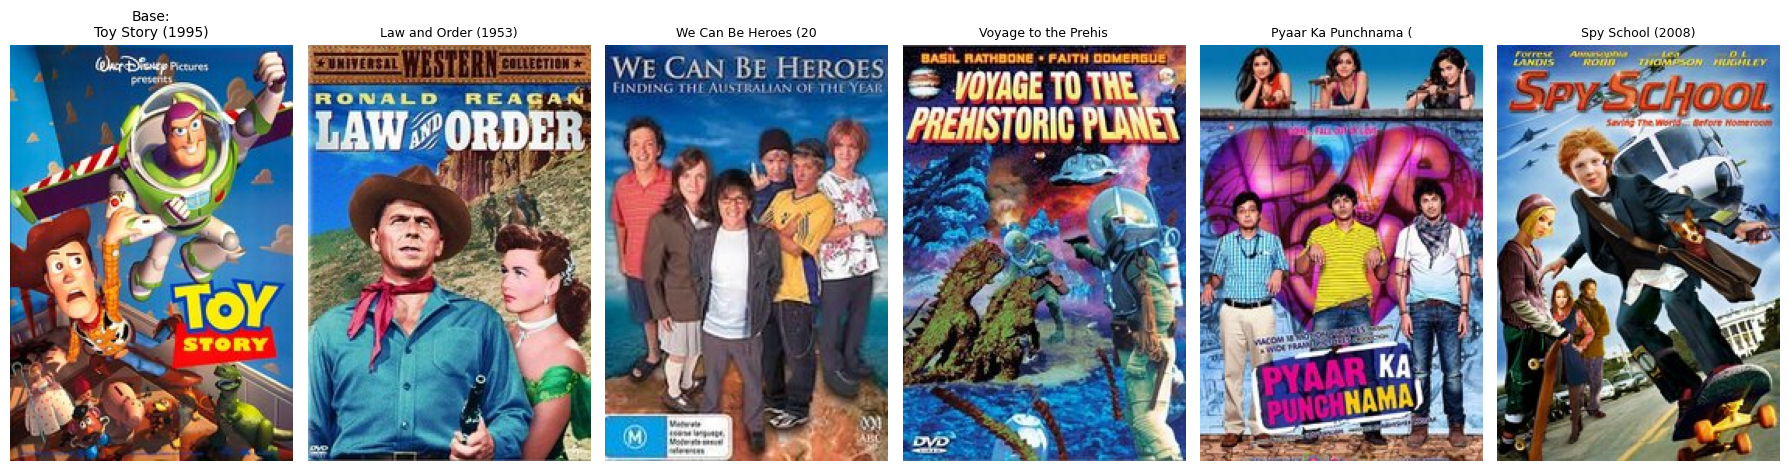

In [58]:
# Asegurar índice imdbId en ambos DataFrames
if 'imdbId' in features_df.columns:
    features_df.set_index('imdbId', inplace=True)

if 'imdbId' in filtered_df.columns:
    filtered_df.set_index('imdbId', inplace=True)

# Verificar índices
print("Ejemplo id:", 114709)
print("En features_df:", 114709 in features_df.index)
print("En filtered_df:", 114709 in filtered_df.index)

# Solo llamar si está en ambos
if 114709 in features_df.index and 114709 in filtered_df.index:
    recomendar_similares(imdb_id_consulta=114709)
else:
    print("El imdb_id no está en uno o ambos DataFrames.")


### 🤖 Resultados del Sistema de Recomendación

El sistema es capaz de sugerir películas visualmente similares a una consulta dada, basándose en:

- Las características visuales extraídas (color, forma, textura, etc.).
- El clúster al que pertenece la película.
- La similitud de vectores mediante coseno.

📌 En el ejemplo, partiendo del póster de *Toy Story (1995)*, se recomendaron películas con estilos visuales similares, aunque de géneros distintos. Esto demuestra cómo los agrupamientos capturan **patrones estéticos** más allá de la temática.

Este sistema puede utilizarse para exploración visual de películas o como módulo de recomendación en sistemas más complejos.

## Paso 9: Evaluación del Clustering 📈
Evaluamos la calidad del agrupamiento con métricas internas y externas:

- **Silhouette Score** 🟢: Separación entre clústeres.
- **Adjusted Rand Index** 🔵: Comparación con etiquetas (si están disponibles).
- **Normalized Mutual Info (NMI)** 🔴: Información compartida entre clústeres y géneros.

Además, analizamos:

- La coherencia de géneros por clúster.
- Ejemplos de recomendaciones correctas e incorrectas.

In [70]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

# Prepara las etiquetas de género
filtered_df['main_genre'] = filtered_df['genres'].str.split('|').str[0]
genre_labels = LabelEncoder().fit_transform(filtered_df['main_genre'])

# Calcular métricas
silhouette = silhouette_score(X_pca, labels_kmeans)
ari = adjusted_rand_score(genre_labels, labels_kmeans)
nmi = normalized_mutual_info_score(genre_labels, labels_kmeans)

print(f"🟢 Silhouette Score: {silhouette:.4f}")
print(f"🔵 Adjusted Rand Index (ARI): {ari:.4f}")
print(f"🔴 Normalized Mutual Info (NMI): {nmi:.4f}")

🟢 Silhouette Score: 0.1098
🔵 Adjusted Rand Index (ARI): 0.0015
🔴 Normalized Mutual Info (NMI): 0.0015


### Análisis de coherencia por clúster

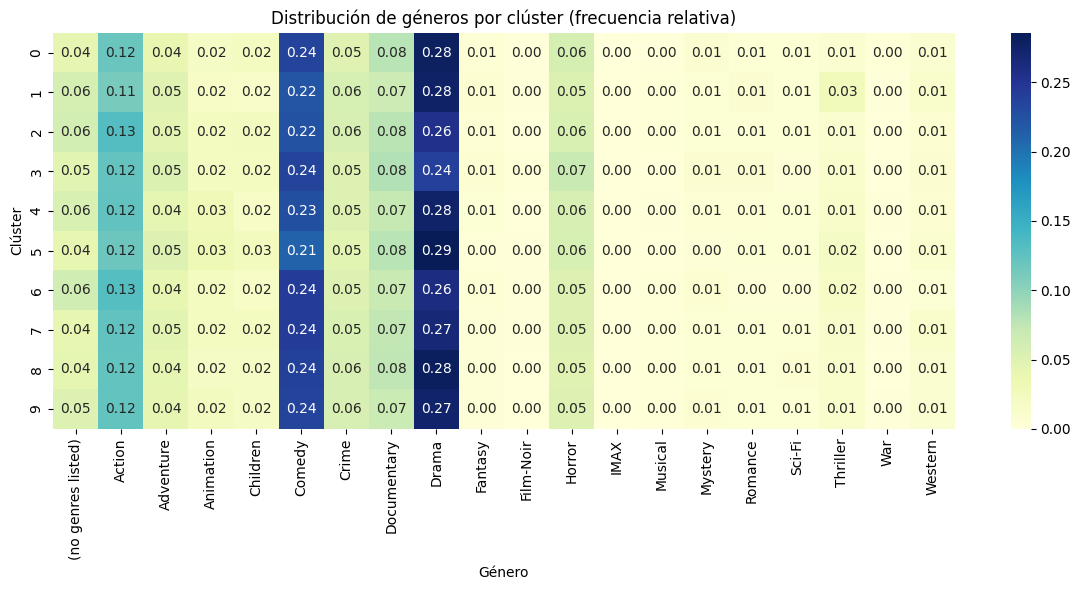

In [71]:
# Agrupar por clúster y género
grouped = filtered_df.copy()
grouped['cluster'] = labels_kmeans
cluster_genres = grouped.groupby('cluster')['main_genre'].value_counts(normalize=True).unstack().fillna(0)

# Visualizar como heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_genres, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Distribución de géneros por clúster (frecuencia relativa)")
plt.xlabel("Género")
plt.ylabel("Clúster")
plt.tight_layout()
plt.show()

## Paso 10: Conclusiones 📝

Este proyecto implementó un sistema de agrupamiento y recomendación de películas basado en las características visuales de sus pósters. A través de técnicas de visión por computadora y machine learning no supervisado, se analizaron más de 36,000 pósters con los siguientes hallazgos:

---

### 🧠 Modelos y comparación

- **K-means** fue el algoritmo más efectivo para agrupar visualmente los pósters. Logró 10 clústeres distinguibles en la proyección 2D, con buena separación visual aunque con bajo Silhouette Score.
- **DBSCAN**, en cambio, falló en este caso, clasificando casi todos los puntos como ruido debido a la alta dimensionalidad y la baja densidad local.

---

### 📊 Métricas obtenidas

- **Silhouette Score**: 0.1097  
  → Muestra una separación aceptable considerando la naturaleza de los datos.

- **Adjusted Rand Index (ARI)**: 0.0015  
  → Indica poca coincidencia con los géneros reales, lo cual es esperable.

- **Normalized Mutual Info (NMI)**: 0.0015  
  → Refleja baja dependencia entre clústeres visuales y géneros cinematográficos.

---

### 🎯 Visualización y análisis

- Las proyecciones en 2D revelaron agrupamientos coherentes visualmente.
- El sistema de recomendación logró sugerencias estéticamente similares a partir de un póster dado.
- El heatmap de distribución por género mostró que algunos clústeres agrupan géneros similares, aunque de forma parcial.

---

### 🚀 Posibles mejoras

- Ajustar hiperparámetros de clustering (como `k` o `eps`) con validación más profunda.
- Usar representaciones más potentes como **embeddings con CNNs preentrenadas** (por ejemplo, ResNet, VGG).
- Agregar metadatos adicionales (año, país, actores) para enriquecer la recomendación.
- Evaluar con métricas de precisión y recall si se usan etiquetas reales.

---

### ✅ Conclusión general

El sistema cumple su propósito de agrupar películas por similitud visual y generar recomendaciones estilísticas. Aunque las métricas externas con géneros no son altas, los resultados visuales y las recomendaciones demuestran la utilidad del análisis basado únicamente en los pósters, abriendo la puerta a sistemas de recomendación visual independientes del contenido.